In [ ]:
# load single trials of rating period

# overview

purpose: look at group average maps from nilearn sngle trials
see if adding amp up and ramp down event increases effect size and eliminates weird artifacts

In [12]:
import numpy as np
import glob
import os, json
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img, new_img_like
from nilearn import image, plotting
import argparse
import matplotlib.pyplot as plt
from surfplot import Plot
from matplotlib import cm
import neuromaps
import nibabel as nib
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps


In [3]:
def plot_surf(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh, size=(200, 600), zoom=1.6, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=nilearn_cmaps['cold_hot'],#cm.seismic, 
                cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()

def plot_surf_box(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh) #, size=(600, 600)) #, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=nilearn_cmaps['cold_hot'],#cm.seismic, 
                cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()


def extract_ses_and_run(flist):
    # Initialize empty sets to store unique values of 'ses' and 'run'
    unique_ses = set()
    unique_run = set()

    # Loop through each file path and extract 'ses-##' and 'run-##' using regular expressions
    for path in flist:
        # Extract 'ses-##' using regular expression
        ses_match = re.search(r'ses-(\d+)', path)
        if ses_match:
            unique_ses.add(ses_match.group(0))

        # Extract 'run-##' using regular expression
        run_match = re.search(r'run-(\d+)', path)
        if run_match:
            unique_run.add(run_match.group(0))

    # Print the unique values of 'ses' and 'run'
    print(f"Unique ses values: {sorted(unique_ses)}")
    print(f"Unique run values: {sorted(unique_run)}")
    return list(sorted(unique_ses)), list(sorted(unique_run))


In [28]:

# %% load participant data. average per run
# beta_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown'
# save_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/deriv03_univariate/contrast_stimhigh-GT-stimlow'
# save_betanpy = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
beta_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown_motor'
save_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv03_univariate/motor'
save_betanpy = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy_motor'

sub_list = sorted(next(os.walk(beta_dir))[1])
groupmean = []; groupmeanL = []; groupmeanH = []
task = 'pain' # 'pain' 'cognitive'
# %%
slurm_id = 2
testlist = sub_list[slurm_id]
# %%
for slurm_id in range(3):
    sub = sub_list[slurm_id]
    print(f"_____________{sub}_____________")
    flist= glob.glob(os.path.join(beta_dir, sub, f"{sub}_*.nii.gz"))
    unique_ses, unique_run = extract_ses_and_run(flist)
    sesmean = []
    sesmean_L, sesmean_H = [], []
    npy_path = pathlib.Path(os.path.join(save_betanpy, sub))
    npy_path.mkdir(parents = True, exist_ok = True)
    for ses in unique_ses:

        runstackL = []; runstackH = []
        for run in unique_run:
            print(run)
            runmeanimg = []
            runmeanconcat = []
            matching_files = []

            motor_flist = glob.glob(os.path.join(beta_dir, sub, f"{sub}_{ses}_{run}*rating*.nii.gz"))

            for motor_fpath in motor_flist:
                motor_img = image.load_img(motor_fpath)
                np.save(os.path.join(npy_path, os.path.splitext(os.path.splitext(os.path.basename(motor_fpath))[0])[0] + '.npy'), motor_img.get_fdata())


_____________sub-0002_____________
Unique ses values: ['ses-01']
Unique run values: ['run-01', 'run-02', 'run-03', 'run-04', 'run-05', 'run-06']
run-01
run-02
run-03
run-04
run-05
run-06
_____________sub-0003_____________
Unique ses values: ['ses-01']
Unique run values: ['run-01', 'run-02', 'run-03', 'run-04', 'run-05', 'run-06']
run-01
run-02
run-03
run-04
run-05
run-06
_____________sub-0004_____________
Unique ses values: ['ses-01']
Unique run values: ['run-01', 'run-02', 'run-03', 'run-04', 'run-05', 'run-06']
run-01
run-02
run-03
run-04
run-05
run-06


In [29]:
stimL_flist

['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy_motor/sub-0004/sub-0004_ses-01_run-04_runtype-pain_event-expectrating_trial-001_cuetype-low.npy',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy_motor/sub-0004/sub-0004_ses-01_run-04_runtype-pain_event-outcomerating_trial-008_cuetype-low_stimintensity-low.npy',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy_motor/sub-0004/sub-0004_ses-01_run-04_runtype-pain_event-expectrating_trial-011_cuetype-high.npy',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy_motor/sub-0004/sub-0004_ses-01_run-04_runtype-pain_event-expectrating_trial-010_cuetype-low.npy',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy_motor/sub-0004/sub-0004_ses-01_run-04_runtype-pain_event-expectrating_trial-005_cuetype-high.npy',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy_motor/sub-0004/sub-00

Calculate group average

In [30]:
sub_list

['sub-0002', 'sub-0003', 'sub-0004']

In [31]:

def extract_ses_and_run(flist):
    # Initialize empty sets to store unique values of 'ses' and 'run'
    unique_ses = set()
    unique_run = set()

    # Loop through each file path and extract 'ses-##' and 'run-##' using regular expressions
    for path in flist:
        # Extract 'ses-##' using regular expression
        ses_match = re.search(r'ses-(\d+)', path)
        if ses_match:
            unique_ses.add(ses_match.group(0))

        # Extract 'run-##' using regular expression
        run_match = re.search(r'run-(\d+)', path)
        if run_match:
            unique_run.add(run_match.group(0))

    # Print the unique values of 'ses' and 'run'
    print(f"Unique ses values: {sorted(unique_ses)}")
    print(f"Unique run values: {sorted(unique_run)}")
    return list(sorted(unique_ses)), list(sorted(unique_run))

# beta_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
beta_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy_motor'

sub_list = sorted(next(os.walk(beta_dir))[1])
 

# %%
import glob
import os
import numpy as np
from itertools import product
task = 'pain'
avgallL = []
avgallH = []
subavgL = []
subavgH = []
suballL = []
suballH = []
for sub in sub_list:
    print(f"_____________{sub}_____________")
    flist = glob.glob(os.path.join(beta_dir, sub, f"{sub}_*.npy"))
    if flist != []:
        unique_ses, unique_run = extract_ses_and_run(flist)
        avgallL = []; avgallH = []
        for ses, run in product(unique_ses, unique_run):
            stimL_flist = glob.glob(os.path.join(beta_dir, sub, f"{sub}_{ses}_{run}*event-*rating*.npy"))
            # stimH_flist = glob.glob(os.path.join(beta_dir, sub, f"{sub}_{ses}_{run}*{task}*event-stimulus_*_stimintensity-high*.npy"))
            runstackL = [];runstackH = []
            if stimL_flist != [] or stimL_flist != []:
                runstackL = [np.load(stimL_fpath).ravel() for stimL_fpath in stimL_flist]
                # runstackH = [np.load(stimH_fpath).ravel() for stimH_fpath in stimH_flist]
                
                avgrunL = np.mean(np.vstack(runstackL), axis=0)
                avgallL.append(avgrunL)
                
                # avgrunH = np.mean(np.vstack(runstackH), axis=0)
                # avgallH.append(avgrunH)
            else:
                continue
        subavgL = np.mean(np.vstack(avgallL), axis=0)
        suballL.append(subavgL)
        print(f"{sub} {len(suballL)}")
        # subavgH = np.mean(np.vstack(avgallH), axis=0)
        # suballH.append(subavgH)
    else: 
        continue

suballLv = np.vstack(suballL)
# suballHv = np.vstack(suballH)
np.save(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-all_event-rating.npy"), suballLv)
# np.save(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{task}_event-stimulus_stimintensity-high.npy"), suballHv)

dict = {'sub': sub_list, 
        'code': '../scripts/step10_nilearn/glm/stim-high_GT_cue-low/numpy_ttest_stim.py'}

with open(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-all_event-rating.json"), 'w') as json_file:
    json.dump(dict, json_file)

_____________sub-0002_____________
Unique ses values: ['ses-01']
Unique run values: ['run-01', 'run-02', 'run-03', 'run-04', 'run-05', 'run-06']
sub-0002 1
_____________sub-0003_____________
Unique ses values: ['ses-01']
Unique run values: ['run-01', 'run-02', 'run-03', 'run-04', 'run-05', 'run-06']
sub-0003 2
_____________sub-0004_____________
Unique ses values: ['ses-01']
Unique run values: ['run-01', 'run-02', 'run-03', 'run-04', 'run-05', 'run-06']
sub-0004 3


load group data

In [32]:
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy_motor'                                     
motor = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-all_event-rating.npy"))


In [33]:
motor.shape #suball

(3, 458294)

In [34]:
# create mask from canlab mask. Use sample single trial as target shape/affine
imgfname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

In [35]:
x,y,z=ref_img.shape
H = []
L = []
for index in range(motor.shape[0]):
    # apply masker onto numpy array (shape of #subjects x voxels)
    L.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, motor[index].reshape(x,y,z)))
    )
    


In [36]:
# fmri_masked_stimhigh = np.vstack(H)
fmri_masked_stimlow = np.vstack(L)
print(fmri_masked_stimlow.shape)

(3, 98053)


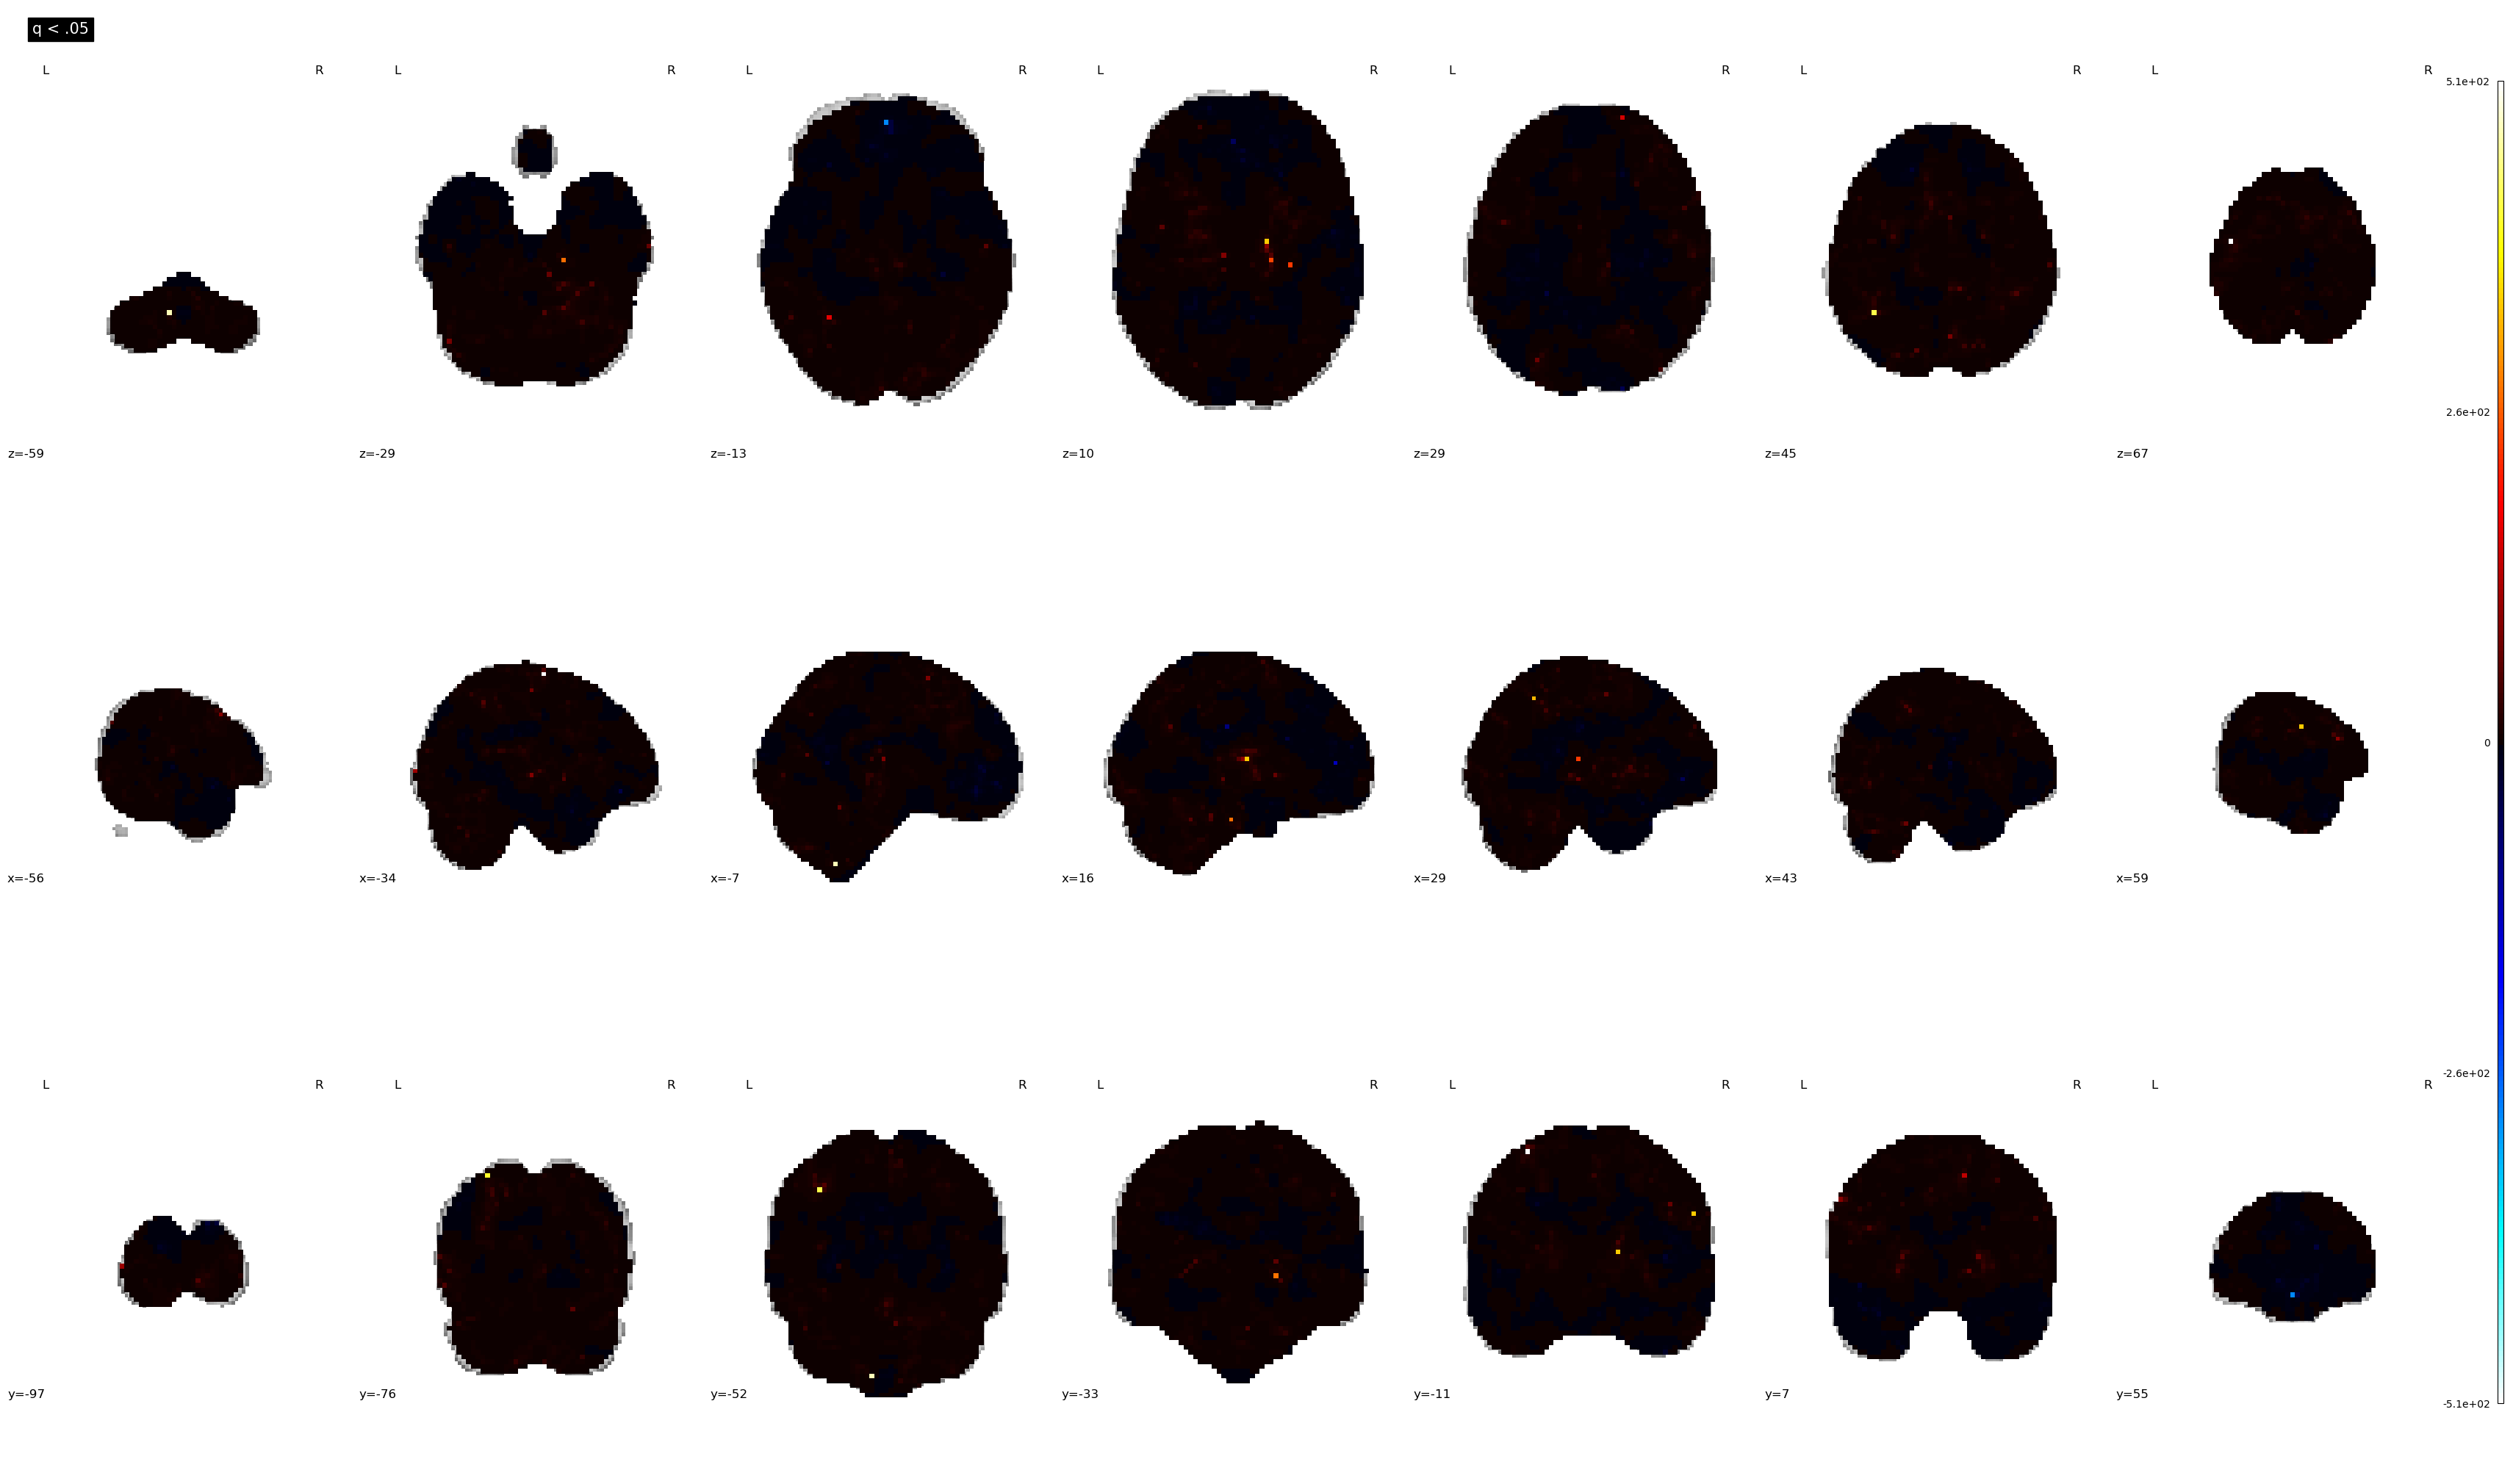

In [37]:
# tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhigh, fmri_masked_stimlow, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
tvalues, pvalues= scipy.stats.ttest_1samp(fmri_masked_stimlow, popmean=0, axis=0, nan_policy='propagate', alternative='two-sided')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
unthres_tmap = nifti_masker.inverse_transform(tvalues)


result_map = np.zeros(fmri_masked_stimlow.shape[1])
result_map[qvalues < .05] = tvalues[qvalues < .05]
con_tmap = nifti_masker.inverse_transform(result_map)


result_map_001 = np.zeros(fmri_masked_stimlow.shape[1])
result_map_001[qvalues < .0001] = tvalues[qvalues < .0001]
con_tmap_001 = nifti_masker.inverse_transform(result_map_001)

plotting.plot_stat_map(unthres_tmap,  display_mode = 'mosaic', title = 'q < .05')
# plotting.plot_stat_map(con_tmap_001,  display_mode = 'mosaic', title = 'q < .001')
# plotting.plot_stat_map(con_bmap, threshold = 1, display_mode = 'mosaic')
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename('singletrial-tmaprampup_task-all_rating_p-unthres.nii.gz')
con_tmap.to_filename('singletrial-tmaprampup_task-all_rating_q-05.nii.gz')
con_tmap_001.to_filename('singletrial-tmaprampup_task-all_rating_q-001.nii.gz')

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


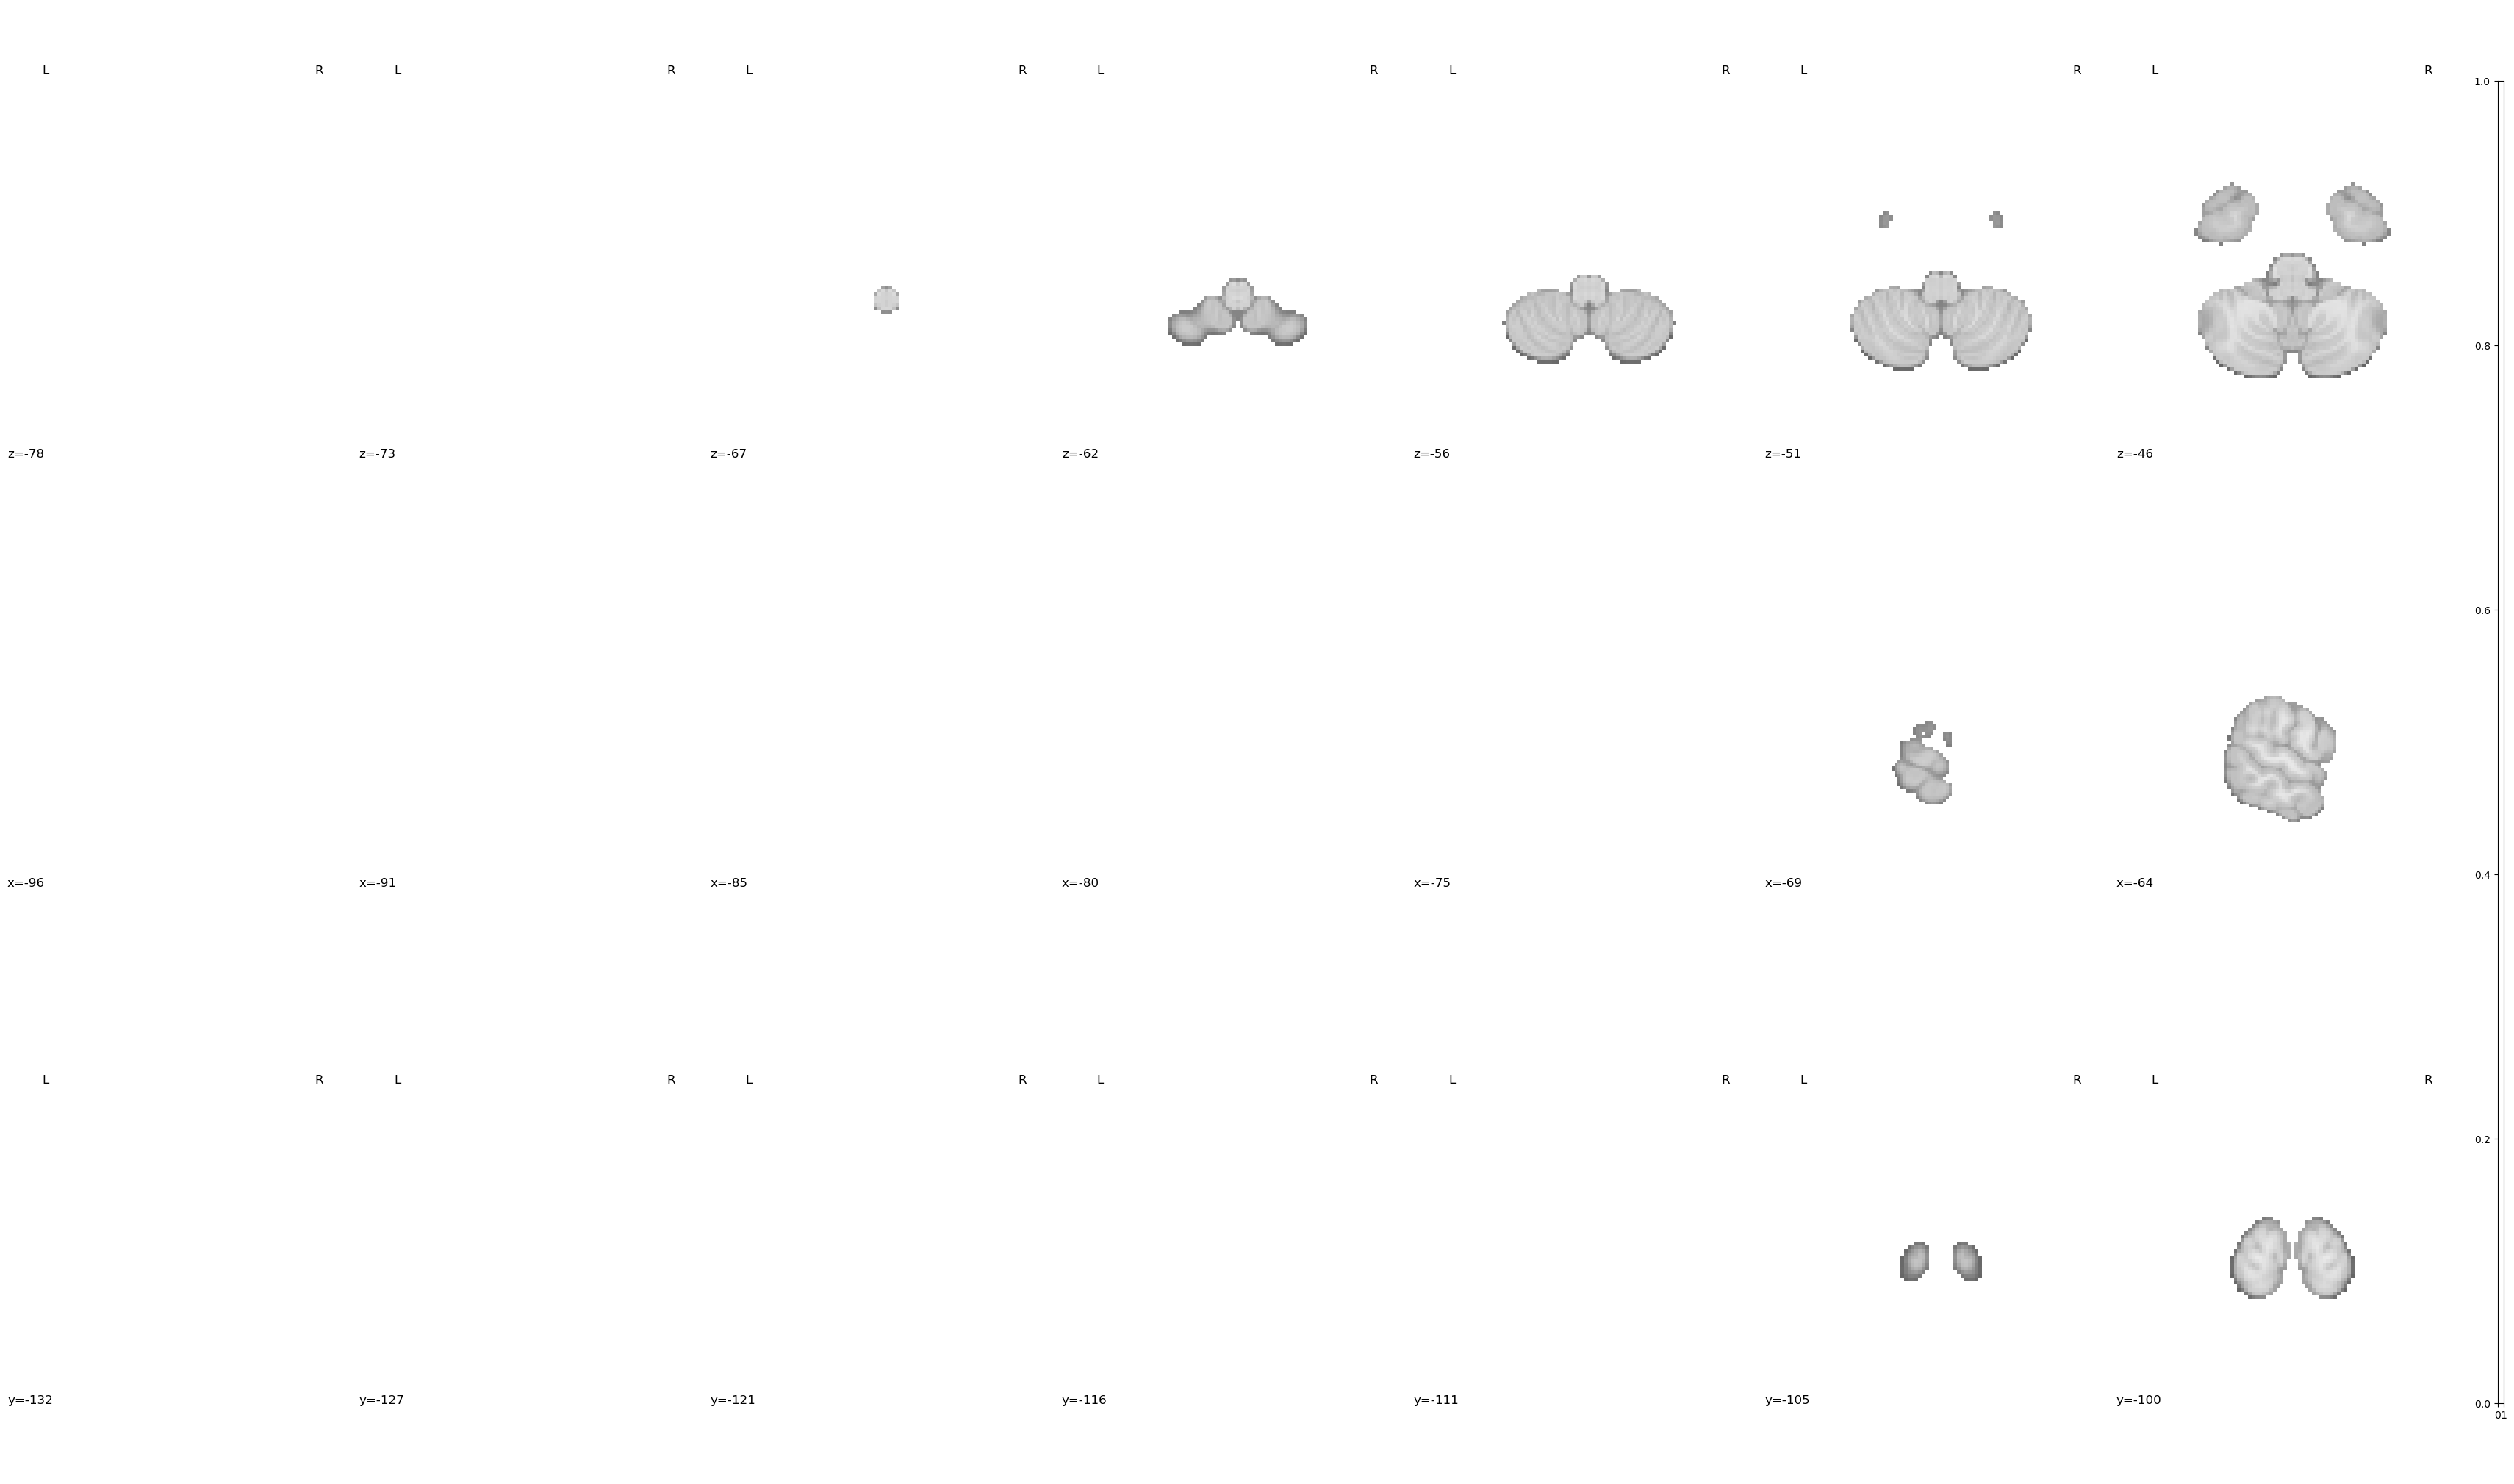

In [39]:
# plotting.plot_stat_map(con_tmap_001,  display_mode = 'mosaic', title = 'q < .001')
plotting.plot_stat_map(con_tmap, threshold = 1, display_mode = 'mosaic')